Stack Overflow question

# Environment

In [148]:
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from bs4 import BeautifulSoup as bs
import re
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Introduction

# Data extraction

The StackExchange data explorer can be use to extract information from the SQL database:
https://data.stackexchange.com/stackoverflow/query/new \
Information about the database schema can be found at:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

* We will extract the *Id*, *Title*, *Body*, and *Tags* from the *Posts* table
* We are working on questions, therefore, *TypeId* must be 1,
* We will generate 5 tags for each question, we therefore select posts with at least 5 *tags*,
* In order to select qualitative enouth posts, we select posts with a minimum *score* of 5,
* We order the extraction by *CreationDate*.

We used SQL request to obtain the .csv file from the *Exchange data explorer*:\
SELECT TOP(50000) Id, Title, Body, Tags\
From Posts\
WHERE PostTypeId = 1\
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\
AND Score >= 5\
ORDER BY CreationDate

In [124]:
df = pd.read_csv('QueryResults.csv',index_col=0)
df.head()

,Title,Body,Tags
Id,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


# Data cleaning

* The database extraction contains html code, we remove it using the *BeautifulSoup* library:

In [125]:
lemmatizer = WordNetLemmatizer()

def extract_body(cell):

    no_code = re.sub('<code>[^>]+</code>', '', cell) # First, we remove the code citations, which is the text between the <code> tags
    text = bs(no_code).get_text() # Then, we remove all the HTML tags
    text = text.lower() # We convert the text to lower
    text = re.sub('[^a-z+]+',' ',text) # We keep the text only
    words = [word.strip() for word in text.split() if len(word.strip()) > 1] # We split the text and exclude single letters
    words = list(set(words).difference(set(stopwords.words('english')))) # we remove the stopwords
    # words = [word for word in words if word not in stopwords.words('english')] # we remove the stopwords
    words = [lemmatizer.lemmatize(word) for word in words] # We lemmatize the result
    result = ','.join(words)

    return result
    

In [126]:
def extract_tags(cell):

    stripped = cell.strip('<').strip('>') # We remove the start and end '>' and '<'
    terms = stripped.split('><') # We split the tags
    result = ','.join(terms)

    return result

* We apply the tranformers on the datasets columns:

In [127]:
df['Body_cleaned'] = df['Body'].apply(extract_body)
df['Tags_cleaned'] = df['Tags'].apply(extract_tags)
df.head()

,Title,Body,Tags,Body_cleaned,Tags_cleaned
Id,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"code,opacity,use,error,worked,give,change,usin...","c#,floating-point,type-conversion,double,decimal"
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"time,value,display,hour,month,relative,like,ag...","c#,datetime,time,datediff,relative-time-span"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"timezone,user,string,determine,page,perhaps,wi...","html,browser,timezone,user-agent,timezone-offset"
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"top,know,test,fastest,fold,value,option,main,c...","performance,algorithm,language-agnostic,unix,pi"
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"test,whole,something,type,matter,actually,chec...","c++,c,sockets,mainframe,zos"


# Data filtering

* In order to keep the most relevant informationb from the cleaned text, we make the following hypothesis:
    * A question about programming is usually about how to program with something (a technology) to do something (a result), or how to optimize the code to do something,
    * Therefore, the verbs and nouns must encapsulate most of the relevant information,
    * In opposition to sentiment analysis, the adverbs are not that relevant.
* We filter the cleaned text in order to keep the verbs and nouns:

In [128]:
def filter_body(cell):

    tokens = nltk.word_tokenize(cell) # We tokenize the words
    tags = nltk.pos_tag(tokens) # We generate the pos tags
    words = [word for word,pos in tags if pos in ['NN','NNP','NNS','NNPS','VB']] # We select the target pos tags
    result = ','.join(words)

    return result

In [129]:
df['Body_filtered'] = df['Body_cleaned'].apply(filter_body)
df.head()

,Title,Body,Tags,Body_cleaned,Tags_cleaned,Body_filtered
Id,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"code,opacity,use,error,worked,give,change,usin...","c#,floating-point,type-conversion,double,decimal","code,opacity,use,error,give,change,application..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"time,value,display,hour,month,relative,like,ag...","c#,datetime,time,datediff,relative-time-span","time,value,display,hour,month,day"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"timezone,user,string,determine,page,perhaps,wi...","html,browser,timezone,user-agent,timezone-offset","timezone,user,string,determine,page,part,stand..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"top,know,test,fastest,fold,value,option,main,c...","performance,algorithm,language-agnostic,unix,pi","know,test,value,option,compiler,system,way,ver..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"test,whole,something,type,matter,actually,chec...","c++,c,sockets,mainframe,zos","test,something,type,matter,check,c++,define,fa..."


# Exploration

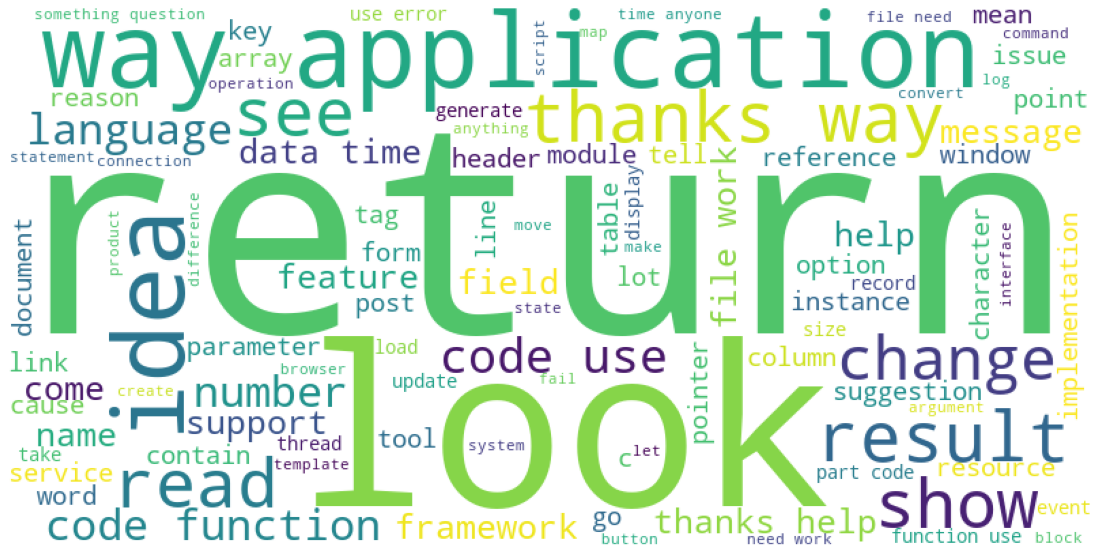

In [137]:
def word_cloud(series):

    wordcloud = WordCloud(background_color = 'white', max_words = 100, width=800, height=400).generate(','.join(series.values))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

word_cloud(df['Body_filtered'])

In [212]:
def plot_frequencies(series,top=10):

    dist = FreqDist(','.join(series).split(','))
    dist_df = pd.DataFrame({'Tag':dist.keys(),'Frequency':dist.values()}).sort_values('Frequency').tail(top)
    fig = px.bar(dist_df,x='Frequency',y='Tag',orientation='h',title=f'Top {top} {series.name} frequencies',height=750)
    fig.show()

plot_frequencies(df['Body_filtered'])

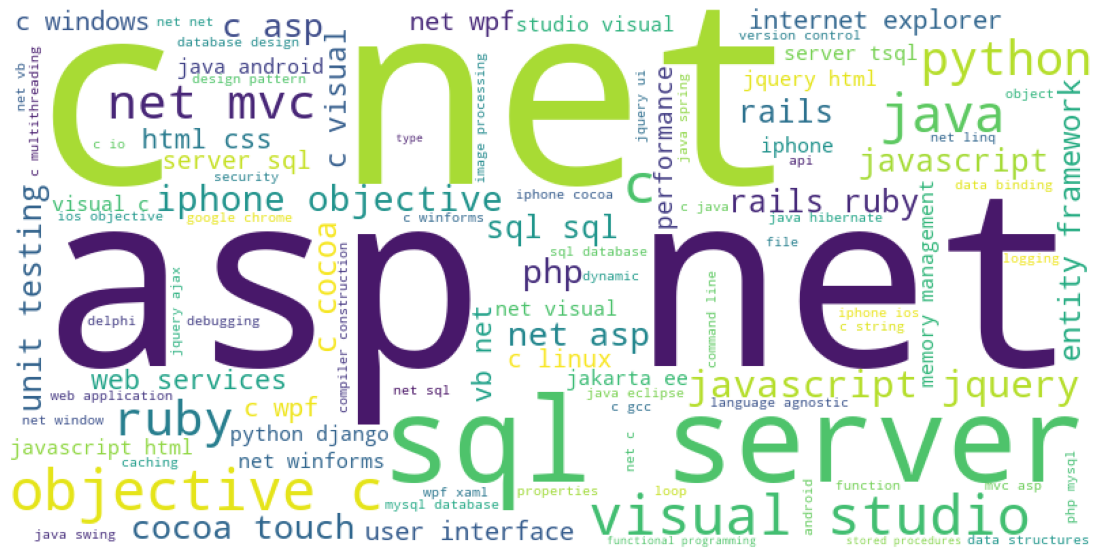

In [138]:
word_cloud(df['Tags_cleaned'])

In [213]:
plot_frequencies(df['Tags_cleaned'])

# Preprocessing

In [214]:
tfid_vectorizer = TfidfVectorizer(max_features=1000)
pd.DataFrame(
    data=tfid_vectorizer.fit_transform(df['Body_filtered']).toarray(),
    index=df.index,
    columns=tfid_vectorizer.get_feature_names_out().tolist()
    )

,ability,abstract,accept,access,account,act,action,activity,add,addition,...,write,writing,www,xaml,xcode,xml,xp,year,yield,zip
Id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6962896,0.0,0.0,0.0,0.0,0.0,0.0,0.177036,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6963028,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6963035,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
